<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-Project 2: Optimization and Text Classification**

## **Project Setup**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

In [6]:
#%cd /content/drive/MyDrive/git/COMP551/projects/p2
%cd /content/drive/MyDrive/Git/COMP551/projects/p2

/content/drive/MyDrive/Git/COMP551/projects/p2


In [4]:
import pandas as pd
import numpy as np
import time
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1234)

## **PART I: Optimaztion**

### **Import Data**

In [7]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'),pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

In [8]:
print('Train set size: ' + str(train_df.shape[0]))
print('Validation set size: ' + str(val_df.shape[0]))
print('Test set size: ' + str(test_df.shape[0]))

total_dataset_size = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
print('Total dataset size: ' + str(total_dataset_size))

# Percentage of positive diabetes diagnostic in train set is 35.5%
train_df['Outcome'].value_counts(normalize=True)


Train set size: 600
Validation set size: 100
Test set size: 68
Total dataset size: 768


0    0.645
1    0.355
Name: Outcome, dtype: float64

### **1. Logisitic regression, learning rate and number of training iterations**
You should first start by running the logistic regression code using the given implementation. This will serve as a baseline for the following steps. Find a learning rate and a number of training iterations such that the model has fully converged to a solution. Make sure to provide empirical evidence supporting your decision (e.g. training and validation accuracy as a function of number of training iterations).

#### **1.1 Logistic Regression**
We leverage the Logisitic Regression notebook which can be found here: 

https://github.com/mravanba/comp551-notebooks/blob/master/LogisticRegression.ipynb

The Logisitic Regression class is modified to allow for stochastic gradient and momentum.

In [9]:
logistic = lambda z: 1./ (1 + np.exp(-z))   #logistic function

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradient_norm = np.inf
        self.stochastic = stochastic
        self.batch_size = batch_size
        self.momentum = momentum

        if self.momentum:
          # array to store gradient of each time step
          self.gradients = [0] * max_iters
          self.momentum_coefficient = momentum_coefficient

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while self.gradient_norm > self.epsilon and t < self.max_iters:
            if self.stochastic:
              g = self.stochastic_gradient(x, y)
            else:
              g = self.gradient(x, y)

            if self.momentum:
              self.gradients[t] = g

            self.gradient_norm = np.linalg.norm(g)

            if self.momentum and t != 0:
              self.w = self.w -self.learning_rate * self.running_average(t)
            else:
              self.w = self.w - self.learning_rate * g 

            t += 1

       
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad                         # size D

    def stochastic_gradient(self, x, y):
        N = x.shape[0]
        inds = np.random.permutation(N)
        x_batch = x[inds,:][:self.batch_size,:]
        y_batch = y[inds][:self.batch_size]
        yh = logistic(np.dot(x_batch, self.w))
        stoch_grad = np.dot(x_batch.T,yh - y_batch)/self.batch_size
        return stoch_grad

    def running_average(self, t):
      running_average = 0
      for i in range(1,t+1):
          running_average += (self.momentum_coefficient ** (t-i)) * (1-self.momentum_coefficient) * self.gradients[i]
      return running_average


#### **1.2 Metrics**

In [10]:
def accuracy(y, yh):
    return np.sum(y == yh)/y.size

def cost_fn(x, w, y, add_bias=False):
    N, D = x.shape                                                       
    if add_bias:
      x = np.column_stack([x,np.ones(N)])
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

#### **1.3 Gradient Descent Hyper-Parameter Tuning**

Method used to visualize the training and validation accuracy convergence/divergence when increasing the maximum number of gradient descent iterations for different learning rates.

In [11]:
def gd_hypertuning_plots(param_range_type='lr', param_range=None, max_iters_range=np.arange(0,100,1), x_train=None, y_train=None, x_val=None, y_val=None, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=0.0001):
  '''
  param_range_type: the code of the parameter we want to tune. 
                    'lr': learning rate
                    'bs': batch size
                    'mc': momentum coefficient

  param_range: the range of the param we want to tune

  max_iters_range: the rage of number of gradient descent iterations

  x_train, y_train, x_val, y_val: the data

  reg_type: type of regression to use

  lr: fixed learning rate to use when tuning other parameters

  stochastic: indicates if stochastic gradient is used

  batch_size: default batch size to use for stochastic gradient

  momentum: indicates if momentum is applied to gradienr descent

  momentum_coefficient: default momentum coefficient
  '''
  
  # setup figures and axis
  figure, axis = plt.subplots(3, 2, figsize=(2, 2), constrained_layout=True)
  figure.set_figheight(20)
  figure.set_figwidth(20)
  #figure.tight_layout(pad=5.0)

  # figure title
  if param_range_type == 'lr':
    param_name = 'Learning Rate'
    label_format = "%0.6f"
  elif param_range_type == 'bs':
    param_name = 'Batch Size'
    label_format = "%d"
  elif param_range_type == 'mc':
    param_name = 'Momentum Coefficient'
    label_format = "%0.6f"

  figure.suptitle('Convergence of Gradient Descent Solution for Different {param}'.format(param=param_name), fontsize=16)
  axis[0][0].set_title("Train Cross-Entropy Loss")
  axis[0][0].set_ylabel("Cost")

  axis[1][0].set_title("Validation Cross-Entropy Loss")
  axis[1][0].set_ylabel("Cost")

  axis[0][1].set_title("Train Accuracy")
  axis[0][1].set_ylabel("Accuracy")

  axis[1][1].set_title("Validation Accuracy")
  axis[1][1].set_ylabel("Accuracy")

  axis[2][0].set_title("Gradient Norm")
  axis[2][0].set_ylabel("Gradient Norm")

  axis[2][1].set_title("Execution Time")
  axis[2][1].set_ylabel("Time")

  min_train_cost, min_val_cost = {'value':np.inf, 'max_iters':0, 'param':0}, {'value':np.inf, 'max_iters':0, 'param':0}
  max_train_acc, max_val_acc = {'value':0, 'max_iters':0, 'param':0}, {'value':0, 'max_iters':0, 'param':0}

  for i,  param in enumerate(param_range):
    
    # setup param we want to tune
    if param_range_type == 'lr':
      lr = param
    elif param_range_type == 'bs':
      batch_size = param
    elif param_range_type == 'mc':
      momentum_coefficient = param

    # y axis ranges
    train_cost_arr = np.zeros((max_iters_range.size))
    val_cost_arr = np.zeros((max_iters_range.size))

    train_acc_arr = np.zeros((max_iters_range.size))
    val_acc_arr = np.zeros((max_iters_range.size))

    g_norm_arr = np.zeros((max_iters_range.size))
    time_arr = np.zeros((max_iters_range.size))

    for j, max_iters in enumerate(max_iters_range):
      t0 = time.time()
      if reg_type == 'logistic':
        reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=False, stochastic=stochastic, batch_size=batch_size, momentum=momentum, momentum_coefficient=momentum_coefficient)
      reg.fit(x_train, y_train)
 
      t1 = time.time()
      time_arr[j] = t1 - t0
      train_cost_arr[j], val_cost_arr[j] = cost_fn(x_train, reg.w, y_train, add_bias=True), cost_fn(x_val, reg.w, y_val, add_bias=True)
      yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
      train_acc_arr[j], val_acc_arr[j] = accuracy(y_train, np.rint(yh_train)), accuracy(y_val, np.rint(yh_val))
      g_norm_arr[j] = reg.gradient_norm

    # keep track of best scores
    cur_min_train_cost, cur_min_val_cost = np.min(train_cost_arr), np.min(val_cost_arr)
    cur_max_train_acc, cur_max_val_acc = np.max(train_acc_arr), np.max(val_acc_arr)

    if cur_min_train_cost < min_train_cost['value']:
      min_train_cost['value'] = cur_min_train_cost
      min_train_cost['max_iters'] = max_iters_range[np.argmin(train_cost_arr)]
      min_train_cost['param'] = param

    if cur_min_val_cost < min_val_cost['value']:
      min_val_cost['value'] = cur_min_val_cost
      min_val_cost['max_iters'] = max_iters_range[np.argmin(val_cost_arr)]
      min_val_cost['param'] = param

    if cur_max_train_acc > max_train_acc['value']:
      max_train_acc['value'] = cur_max_train_acc
      max_train_acc['max_iters'] = max_iters_range[np.argmax(train_acc_arr)]
      max_train_acc['param'] = param

    if cur_max_val_acc > max_val_acc['value']:
      max_val_acc['value'] = cur_max_val_acc
      max_val_acc['max_iters'] = max_iters_range[np.argmax(val_acc_arr)]
      max_val_acc['param'] = param

    # add plot lines
    axis[0][0].plot(max_iters_range, train_cost_arr, label=label_format % param)
    axis[1][0].plot(max_iters_range, val_cost_arr, label=label_format % param)
    axis[0][1].plot(max_iters_range, train_acc_arr, label=label_format % param)
    axis[1][1].plot(max_iters_range, val_acc_arr, label=label_format % param)
    axis[2][0].plot(max_iters_range, g_norm_arr, label=label_format % param)
    axis[2][1].plot(max_iters_range, time_arr, label=label_format % param)

  for subplot in axis.reshape(-1):
    subplot.set_xlabel("Number of Iterations")
    subplot.legend()
  plt.show()

  print("Minimal train cost: {cost}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(cost=min_train_cost['value'], param_name=param_name, param=min_train_cost['param'], max_iters=min_train_cost['max_iters']))
  print("Minimal validation cost: {cost}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(cost=min_val_cost['value'], param_name=param_name, param=min_val_cost['param'], max_iters=min_val_cost['max_iters']))

  print("Maximal train accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=max_train_acc['value'], param_name=param_name, param=max_train_acc['param'], max_iters=max_train_acc['max_iters']))
  print("Maximal validation accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=max_val_acc['value'], param_name=param_name, param=max_val_acc['param'], max_iters=max_val_acc['max_iters']))





#### **1.4 Learning Rate and Number of Iterations Tuning**

The learning rate and the max number of iterations will be determined empirically. We will start with high learning rates. The accuracy per number of iterations si plotted for each learning rate. If we see that the accuracy oscillates and does not converge to a value, it means that our learning is too high.

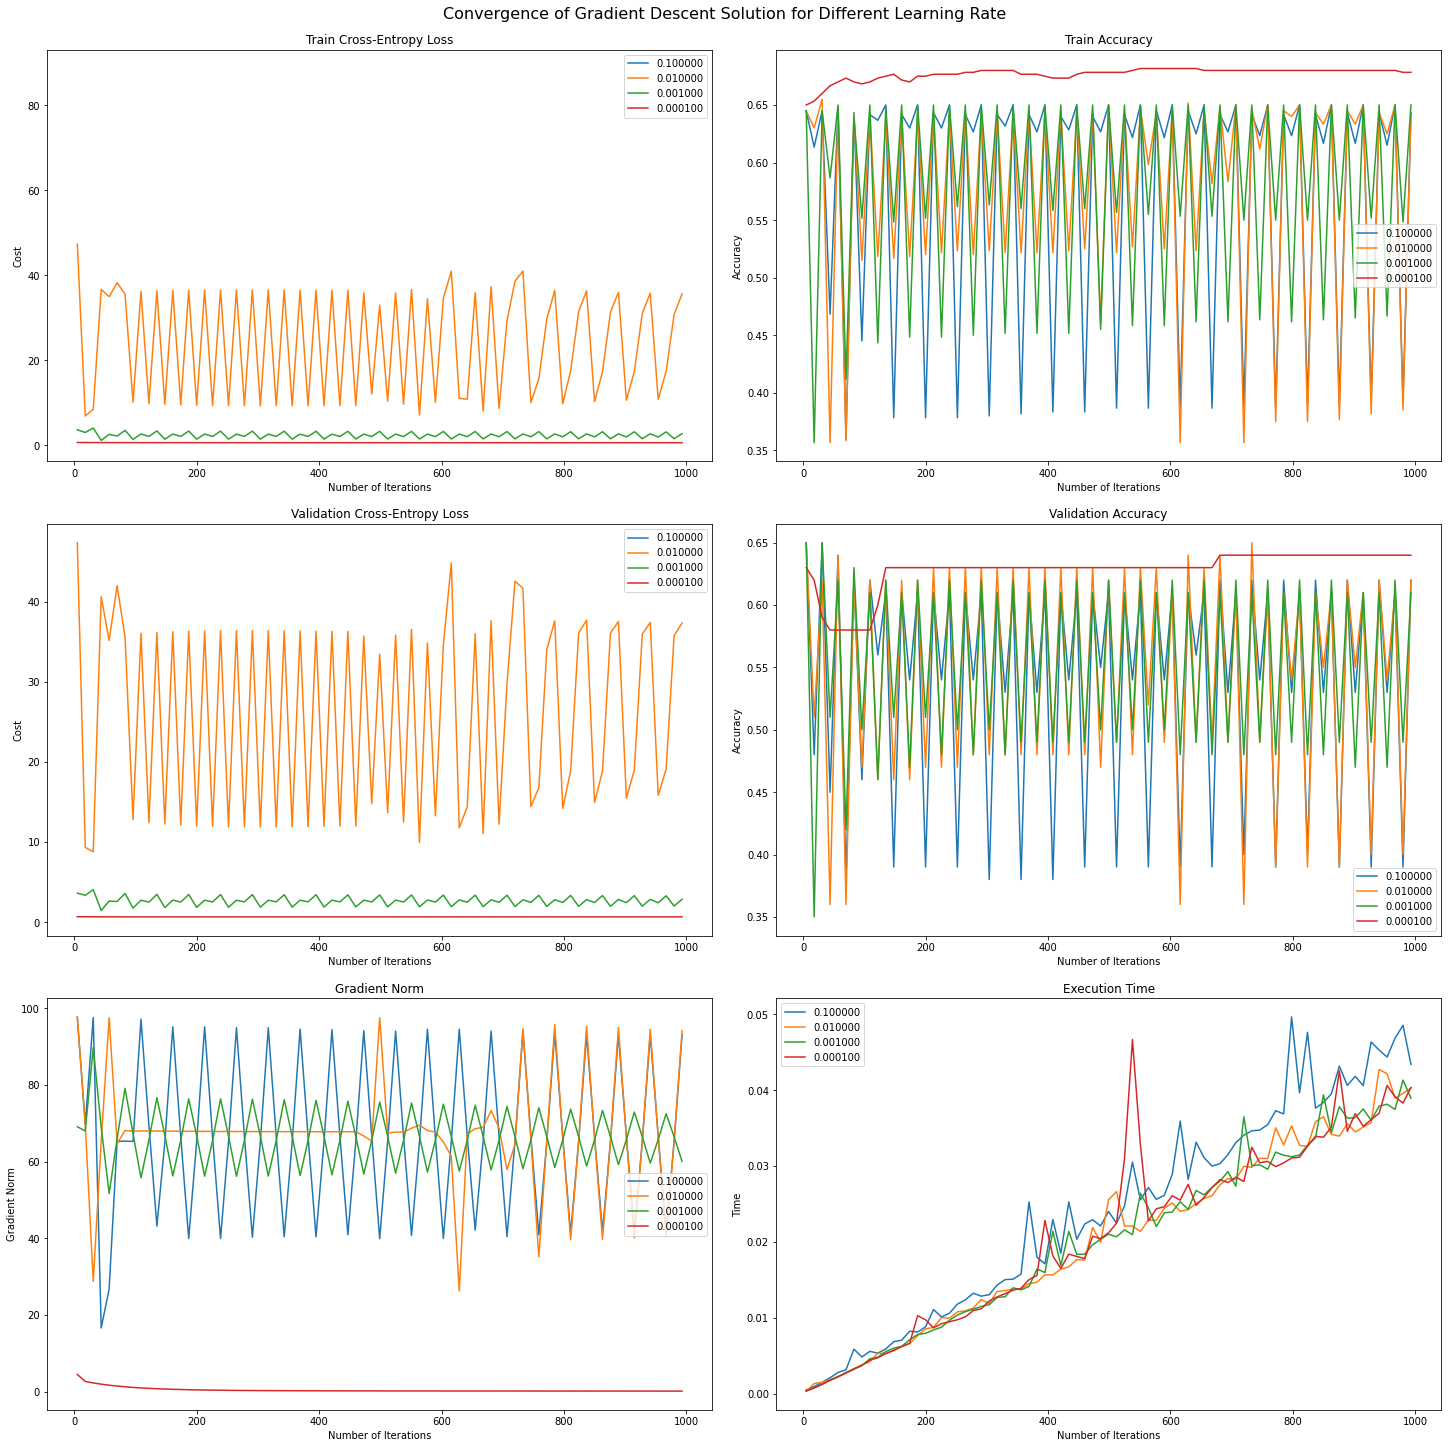

Minimal train cost: 0.6141781758288682
Learning Rate: 0.0001
Number of iterations: 993

Minimal validation cost: 0.6580093956224722
Learning Rate: 0.0001
Number of iterations: 161

Maximal train accuracy: 0.6816666666666666
Learning Rate: 0.0001
Number of iterations: 551

Maximal validation accuracy: 0.65
Learning Rate: 0.1
Number of iterations: 5



In [ ]:
lr_range = np.array([0.1,0.01,0.001, 0.0001])
max_iters_range = np.arange(5,1000,13)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

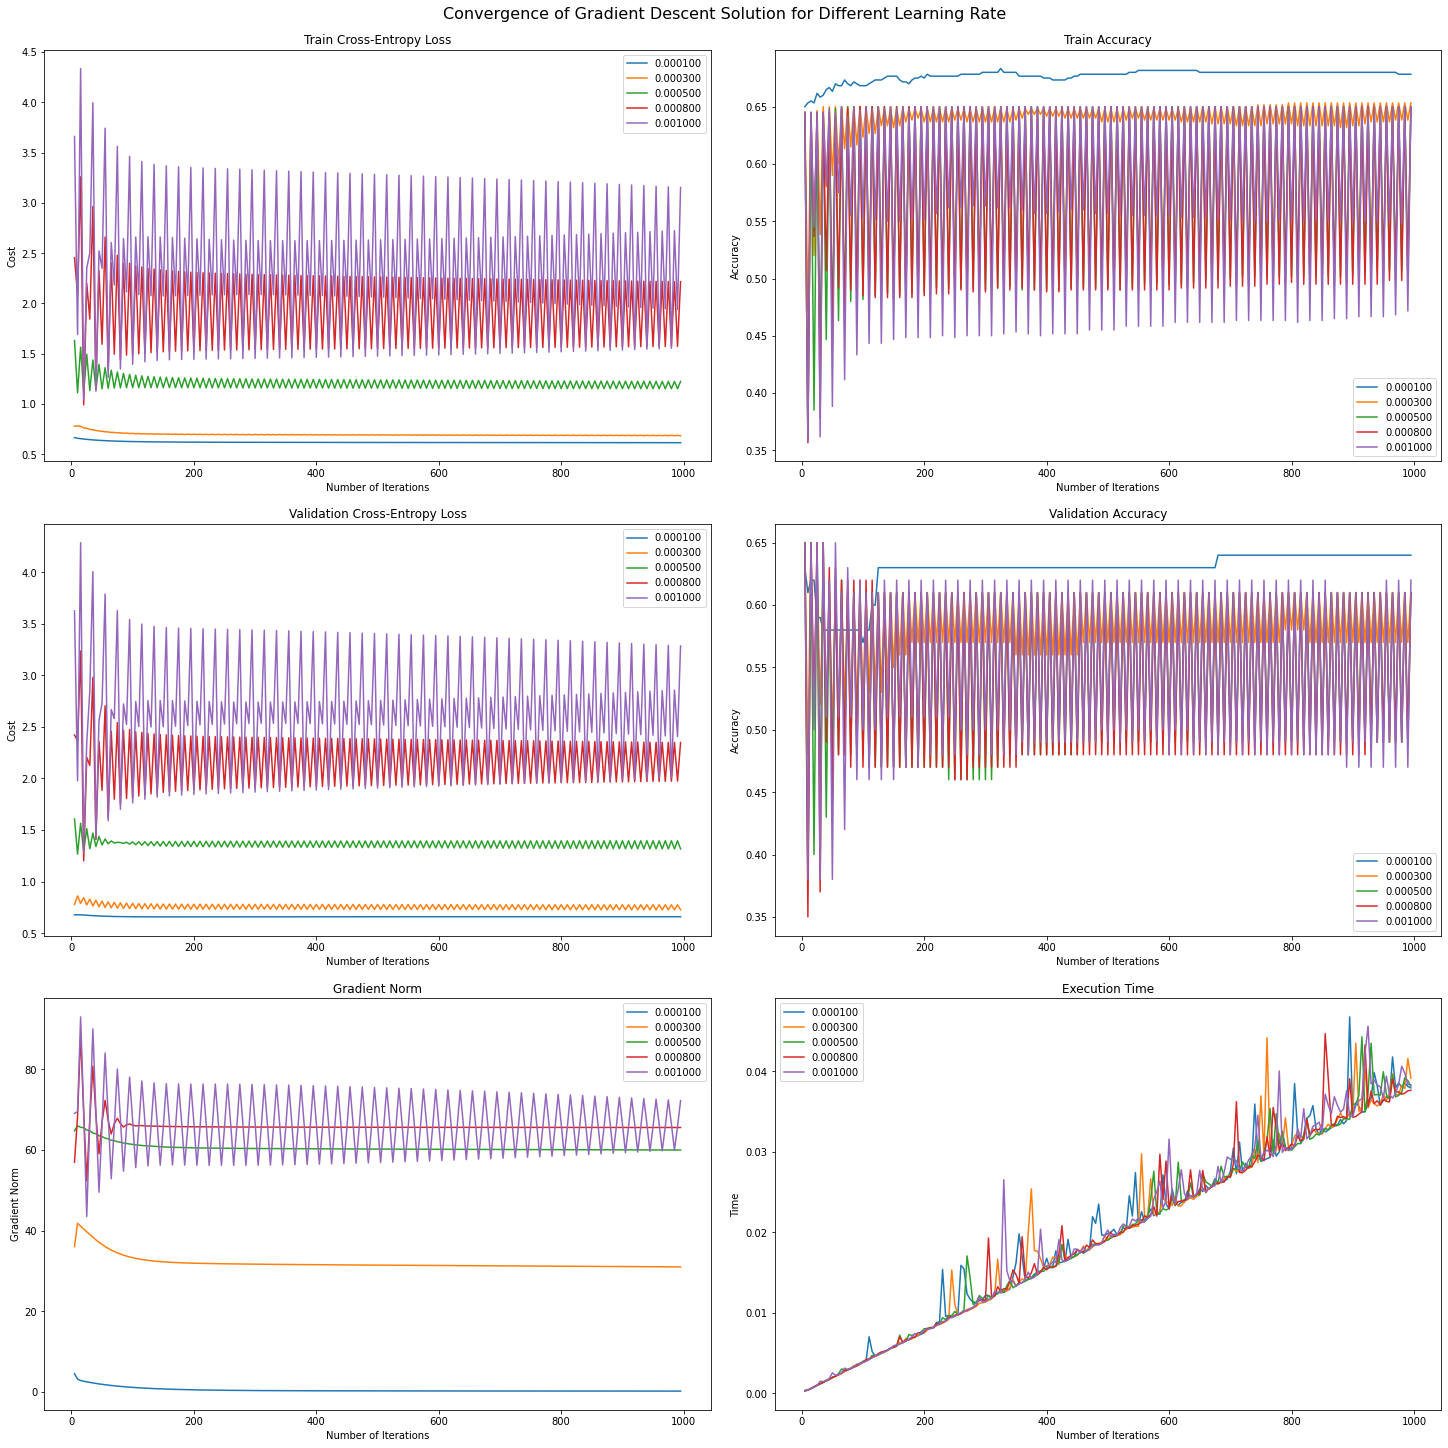

Minimal train cost: 0.6141708362066902
Learning Rate: 0.0001
Number of iterations: 995

Minimal validation cost: 0.6580063027306937
Learning Rate: 0.0001
Number of iterations: 165

Maximal train accuracy: 0.6833333333333333
Learning Rate: 0.0001
Number of iterations: 325

Maximal validation accuracy: 0.65
Learning Rate: 0.0003
Number of iterations: 5



In [ ]:
lr_range = np.array([0.0001,0.0003, 0.0005, 0.0008, 0.001])
max_iters_range = np.arange(5,1000,5)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

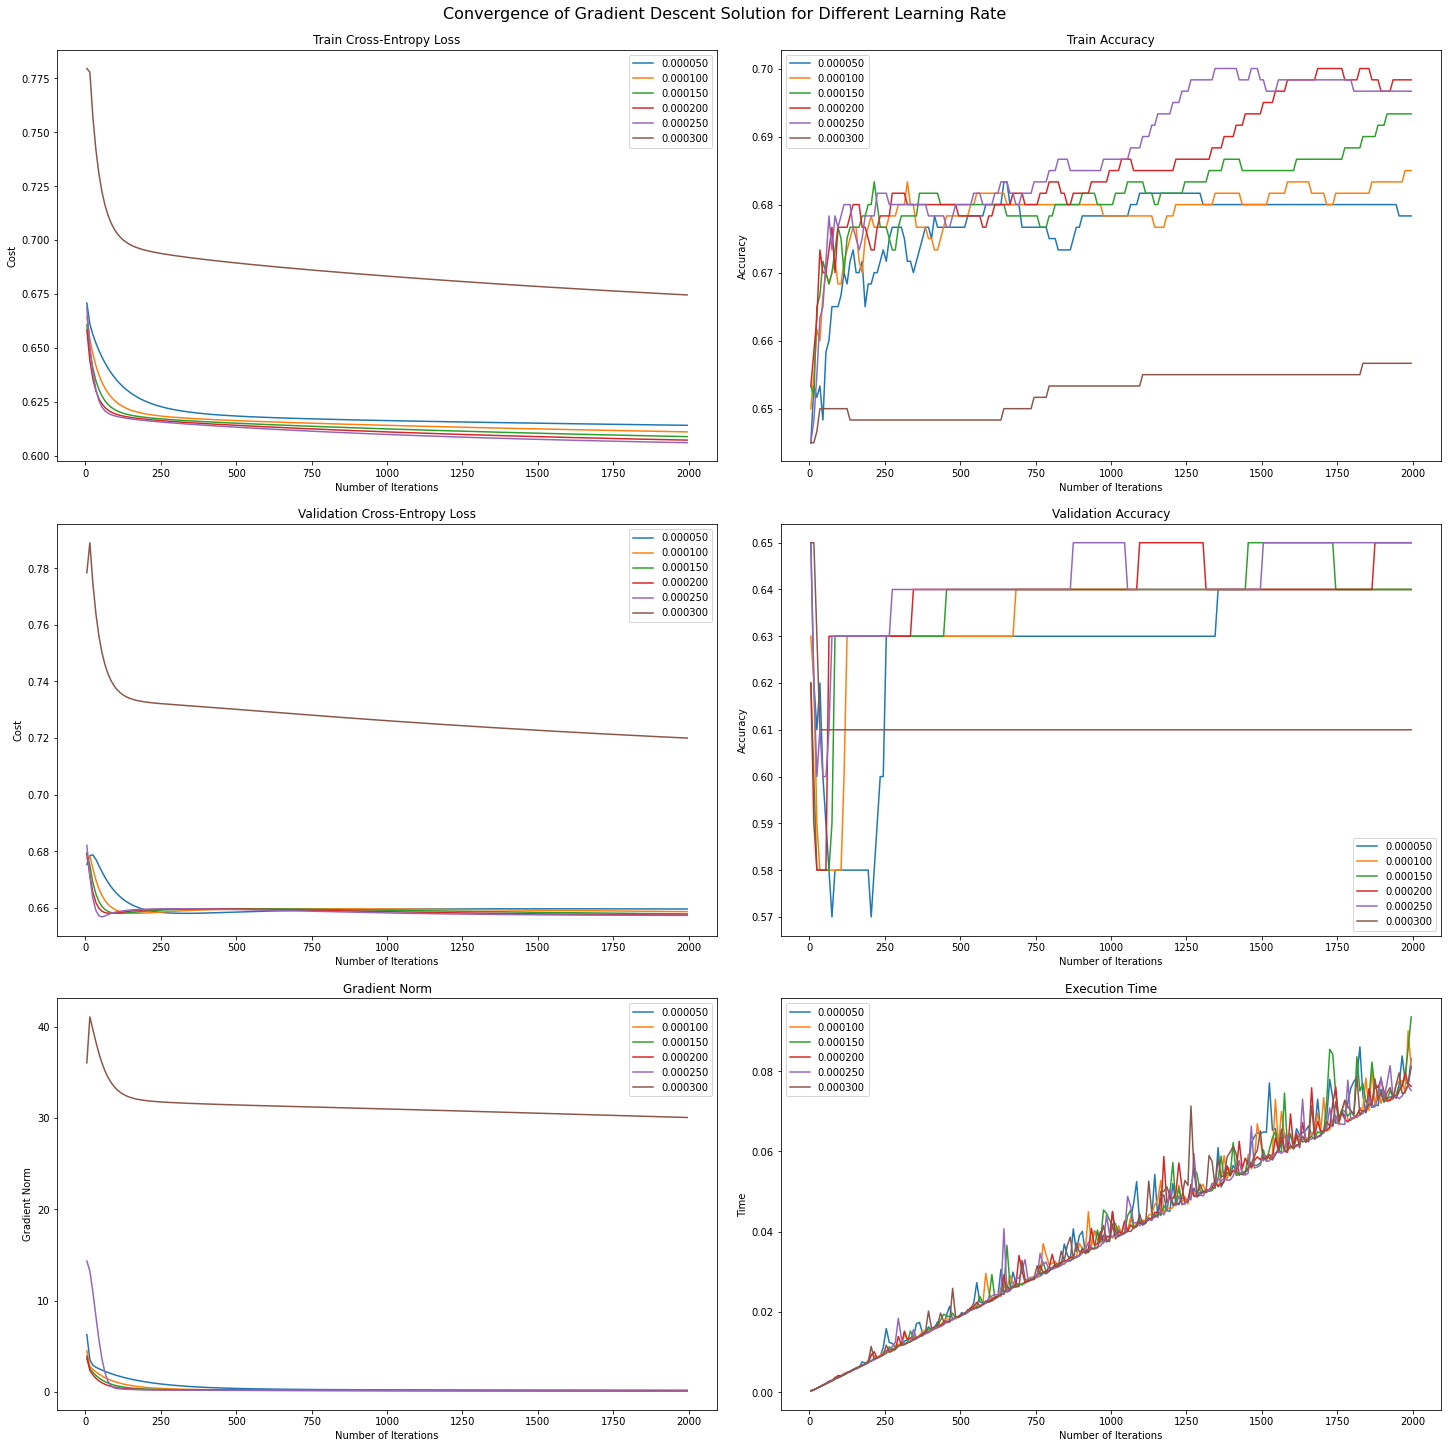

Minimal train cost: 0.6061068976145808
Learning Rate: 0.00025
Number of iterations: 1995

Minimal validation cost: 0.6567508292236195
Learning Rate: 0.00025
Number of iterations: 55

Maximal train accuracy: 0.7
Learning Rate: 0.0002
Number of iterations: 1685

Maximal validation accuracy: 0.65
Learning Rate: 5e-05
Number of iterations: 5



In [62]:
lr_range = np.array([0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003])
max_iters_range = np.arange(5,2000,10)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

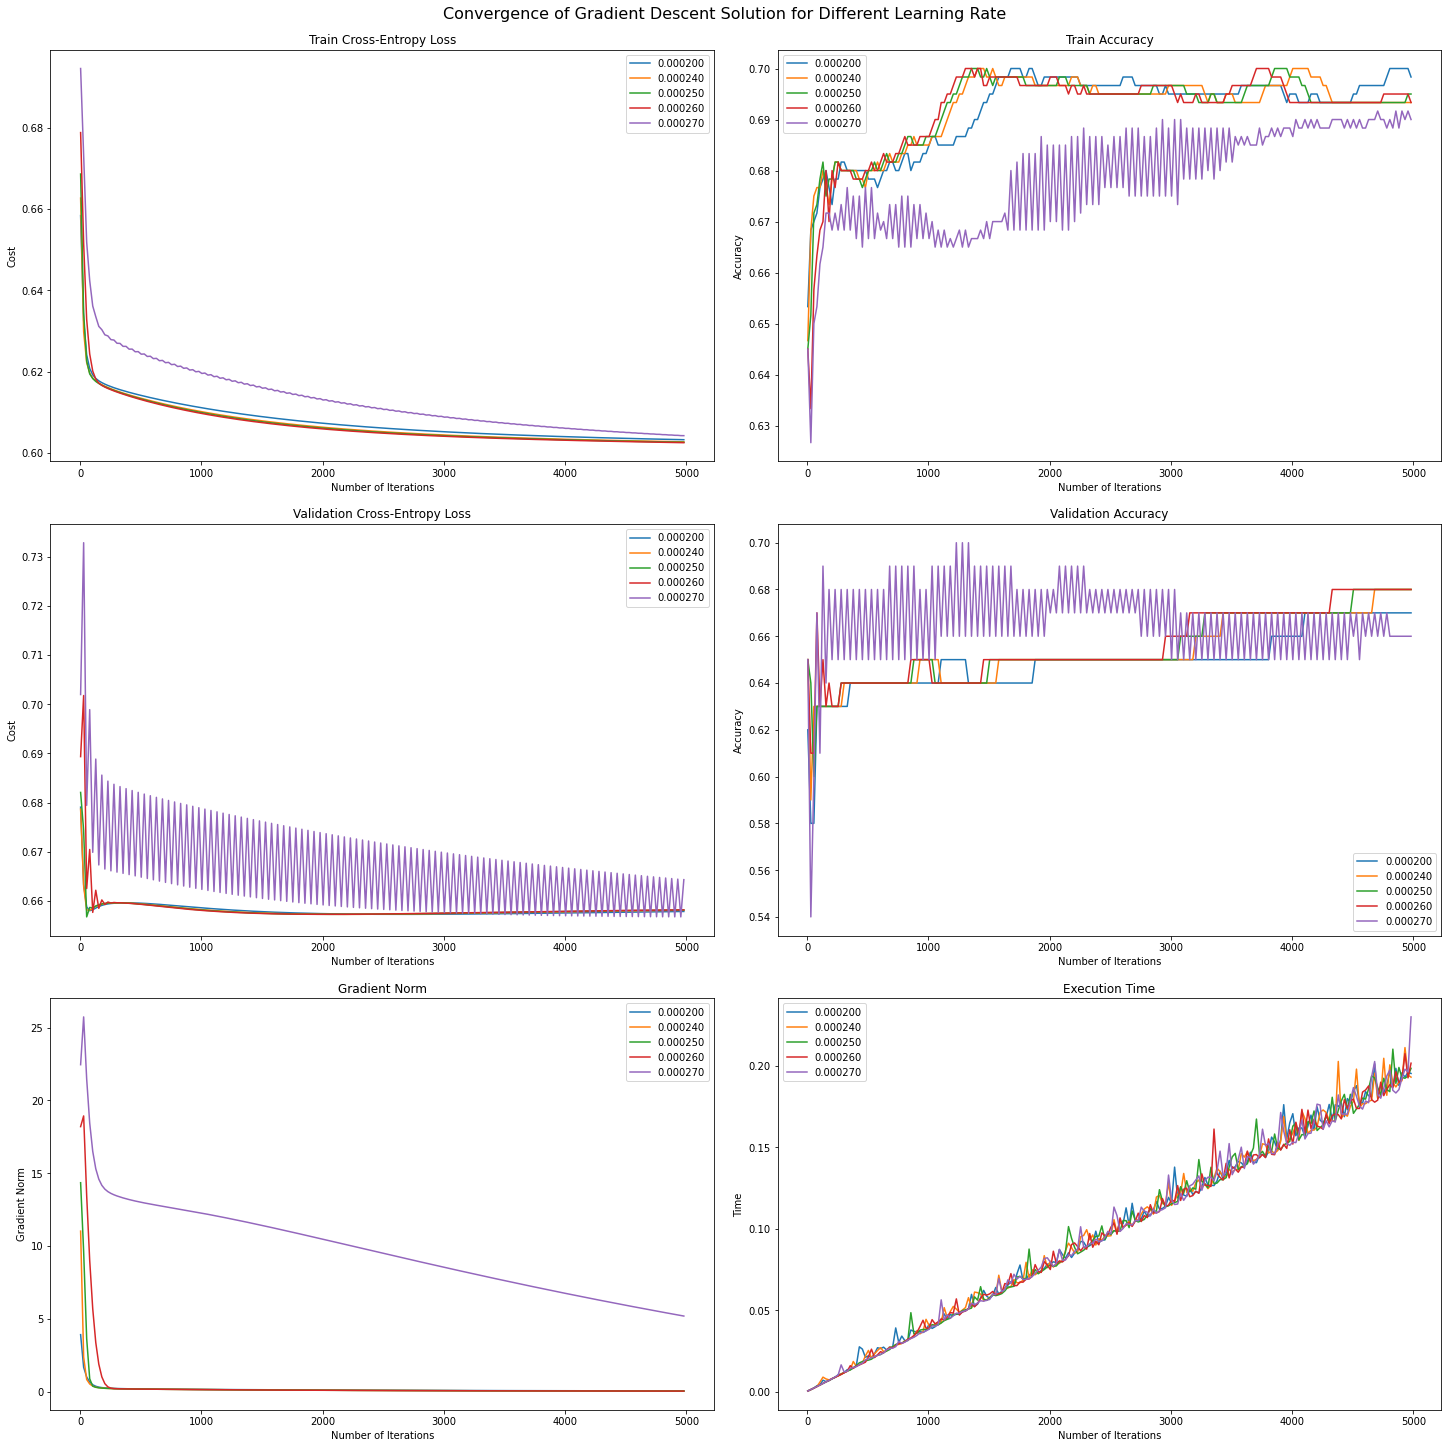

Minimal train cost: 0.6024994836092261
Learning Rate: 0.00026
Number of iterations: 4980

Minimal validation cost: 0.6567491956597153
Learning Rate: 0.00027
Number of iterations: 4955

Maximal train accuracy: 0.7
Learning Rate: 0.0002
Number of iterations: 1680

Maximal validation accuracy: 0.7
Learning Rate: 0.00027
Number of iterations: 1230



In [64]:
lr_range = np.array([0.0002, 0.00024, 0.00025, 0.00026, 0.00027])
max_iters_range = np.arange(5,5000,25)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)


From the empirically testing above, its hard to tell which learning rate between 0.0002 and 0.00027 will yield the best results with the fastest convergence. We will run the algorithm for each of the following rate until convergence: 0.00020 up until we see a decrease in performance. 

In [80]:
def converge(lr, max_iters, epsilon, batch_size):
  
  stochastic=True
  if batch_size==1:
     stochastic=False 
      
  reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True, momentum=False, momentum_coefficient=0.9, stochastic=stochastic, batch_size=batch_size)
  reg.fit(x_train, y_train)

  # compute error
  yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
  y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
  acc_train, acc_val = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val)

  print("train accuracy: {acc_train}".format(acc_train=acc_train))
  print("validation accuracy: {acc_val}".format(acc_val=acc_val))


In [86]:
lr = 0.0002
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1367503 iterations, with norm of the gradient equal to 0.009999995846029335
the weight found: [ 1.31495577e-01  2.74292662e-02 -1.70700623e-02 -2.71391408e-03
  2.10108246e-04  5.10398768e-02  5.95657221e-01  2.93699533e-03
 -5.31192224e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [84]:
lr = 0.00021
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1302384 iterations, with norm of the gradient equal to 0.009999994470234728
the weight found: [ 1.31495578e-01  2.74292675e-02 -1.70700614e-02 -2.71391419e-03
  2.10108138e-04  5.10398822e-02  5.95657261e-01  2.93699653e-03
 -5.31192270e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [85]:
lr = 0.00022
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1243185 iterations, with norm of the gradient equal to 0.009999992337647997
the weight found: [ 1.31495580e-01  2.74292693e-02 -1.70700602e-02 -2.71391434e-03
  2.10107985e-04  5.10398898e-02  5.95657317e-01  2.93699824e-03
 -5.31192336e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [87]:
lr = 0.00023
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1189133 iterations, with norm of the gradient equal to 0.009999996687769113
the weight found: [ 1.31495577e-01  2.74292664e-02 -1.70700621e-02 -2.71391410e-03
  2.10108228e-04  5.10398778e-02  5.95657228e-01  2.93699554e-03
 -5.31192232e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [88]:
lr = 0.00024
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1139586 iterations, with norm of the gradient equal to 0.00999999499115926
the weight found: [ 1.31495579e-01  2.74292679e-02 -1.70700611e-02 -2.71391423e-03
  2.10108100e-04  5.10398841e-02  5.95657275e-01  2.93699695e-03
 -5.31192286e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [89]:
lr = 0.00025
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1094003 iterations, with norm of the gradient equal to 0.00999999126005288
the weight found: [ 1.31495582e-01  2.74292710e-02 -1.70700592e-02 -2.71391448e-03
  2.10107849e-04  5.10398965e-02  5.95657368e-01  2.93699975e-03
 -5.31192394e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [90]:
lr = 0.00026
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1051926 iterations, with norm of the gradient equal to 0.009999992106737316
the weight found: [ 1.31495582e-01  2.74292706e-02 -1.70700594e-02 -2.71391446e-03
  2.10107877e-04  5.10398951e-02  5.95657360e-01  2.93699942e-03
 -5.31192382e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [91]:
lr = 0.00027
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1012967 iterations, with norm of the gradient equal to 0.009999992817809528
the weight found: [ 1.31495582e-01  2.74292703e-02 -1.70700597e-02 -2.71391468e-03
  2.10107881e-04  5.10398933e-02  5.95657452e-01  2.93699880e-03
 -5.31192372e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [92]:
lr = 0.00028
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 975474 iterations, with norm of the gradient equal to 0.009999994672278498
the weight found: [ 1.31496371e-01  2.74292139e-02 -1.70701333e-02 -2.71413539e-03
  2.10093631e-04  5.10392031e-02  5.95747305e-01  2.93663607e-03
 -5.31191628e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [93]:
lr = 0.00029
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 935902 iterations, with norm of the gradient equal to 0.00999999158295687
the weight found: [ 1.31501547e-01  2.74288601e-02 -1.70706051e-02 -2.71557987e-03
  2.09999212e-04  5.10347522e-02  5.96335302e-01  2.93427807e-03
 -5.31187299e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [94]:
lr = 0.0003
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 891096 iterations, with norm of the gradient equal to 0.009999994849797442
the weight found: [ 1.31523943e-01  2.74274369e-02 -1.70725790e-02 -2.72180425e-03
  2.09585413e-04  5.10160001e-02  5.98868232e-01  2.92421731e-03
 -5.31172076e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75


In [95]:
lr = 0.00031
max_iters = 5000000
epsilon = 0.01

converge(lr, max_iters, epsilon, 1)

terminated after 1011012 iterations, with norm of the gradient equal to 0.009999562110317014
the weight found: [ 1.33194113e-01  2.88087953e-02 -1.62065969e-02 -2.84335611e-03
  9.69289732e-05  5.66985117e-02  6.42880425e-01  4.17292027e-03
 -5.80013059e+00]
train accuracy: 0.775
validation accuracy: 0.75


Todo: write function to run all of these tests and display on graph

#### **1.5 Results**

From the empirically testing above, we decided to use a learning rate of 0.0003 because it yields the fastest convergence speed with highest train and validation set accuracy. 

To further our investigation of learning rate, we try a smaller and larger learning rate to analyze the effect on convergence speed and accuracy. 

In [108]:
def eval(lr, max_iters, epsilon, batch_size):
  
  stochastic=True
  if batch_size==1:
     stochastic=False 
      
  reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True, momentum=False, momentum_coefficient=0.9, stochastic=stochastic, batch_size=batch_size)
  reg.fit(x_train, y_train)

  # compute error
  yh_train, yh_val, yh_test = reg.predict(x_train), reg.predict(x_val), reg.predict(x_test)
  y_pred_train, y_pred_val, y_pred_test = np.rint(yh_train), np.rint(yh_val), np.rint(yh_test)
  acc_train, acc_val, acc_test = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val), accuracy(y_test, y_pred_test)

  print("train accuracy: {acc_train}".format(acc_train=acc_train))
  print("validation accuracy: {acc_val}".format(acc_val=acc_val))
  print("test accuracy: {acc_test}".format(acc_test=acc_test))

In [109]:
lr = 0.0003
max_iters = 5000000
epsilon = 0.01

eval(lr, max_iters, epsilon, 1)

terminated after 891096 iterations, with norm of the gradient equal to 0.009999994849797442
the weight found: [ 1.31523943e-01  2.74274369e-02 -1.70725790e-02 -2.72180425e-03
  2.09585413e-04  5.10160001e-02  5.98868232e-01  2.92421731e-03
 -5.31172076e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75
test accuracy: 0.7647058823529411


In [110]:
# Very small learning rate
lr = 0.0001
max_iters = 5000000
epsilon = 0.01

eval(lr, max_iters, epsilon, 1)

terminated after 2735005 iterations, with norm of the gradient equal to 0.009999998232974174
the weight found: [ 1.31495571e-01  2.74292616e-02 -1.70700652e-02 -2.71391370e-03
  2.10108625e-04  5.10398581e-02  5.95657082e-01  2.93699111e-03
 -5.31192062e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75
test accuracy: 0.7647058823529411


At 0.0001 the learning is much smaller than c. We still get the same accuracy since both algorithm end up finding the same minima, however a smaller learning rate leads a longer time before convergence. 

In [111]:
# Very large learning rate
lr = 0.001
max_iters = 5000000
epsilon = 0.01

eval(lr, max_iters, epsilon, 1)

terminated after 5000000 iterations, with norm of the gradient equal to 47.22076757330991
the weight found: [ 4.57314335e-01  1.22981651e-01 -2.44882084e-02 -1.81309854e-02
  2.01005789e-02  2.52014003e-01  2.35638598e+00  3.99253559e-02
 -2.45413972e+01]
train accuracy: 0.6766666666666666
validation accuracy: 0.68
test accuracy: 0.6176470588235294


At 0.001 the learning rate is too big, if it ever converges it would take very long. It is also very possible that it oscillates around the minima indefinitly passing it by. 

### **2. Mini-batch Stochastic Gradient Descent**

Implement mini-batch stochastic gradient descent. Then, using growing minibatch sizes (e.g. 8, 16, 32, ...) compare the convergence speed and the quality of the final solution to the fully batched baseline. What configuration works the best among the ones you tried ?

In [97]:
lr = 0.0003
max_iters = 10000000
epsilon = 0.01
batch_size=8

converge(lr, max_iters, epsilon, batch_size)

terminated after 10000000 iterations, with norm of the gradient equal to 32.01389077628602
the weight found: [ 2.15898720e-01  5.51515121e-02 -1.35954257e-02 -8.12960824e-03
  1.28209883e-02  1.28556678e-01  1.28329178e+00  1.81414451e-02
 -1.17836845e+01]
train accuracy: 0.675
validation accuracy: 0.66


In [102]:
lr = 0.0003
max_iters = 10000000
epsilon = 0.01
batch_size=32

converge(lr, max_iters, epsilon, batch_size)

terminated after 10000000 iterations, with norm of the gradient equal to 25.792151547973646
the weight found: [ 1.68007988e-01  3.96673989e-02 -1.75599501e-02 -5.51001339e-03
 -2.56098856e-03  9.99080310e-02  1.00918462e+00  1.04975851e-02
 -9.57909139e+00]
train accuracy: 0.7583333333333333
validation accuracy: 0.78


In [103]:
lr = 0.0003
max_iters = 10000000
epsilon = 0.01
batch_size=128

converge(lr, max_iters, epsilon, batch_size)

terminated after 10000000 iterations, with norm of the gradient equal to 8.931114999650095
the weight found: [ 1.51890330e-01  3.69375217e-02 -1.14725562e-02 -3.63942888e-03
  2.54212011e-03  9.12869759e-02  9.17923504e-01  1.06305240e-02
 -8.85470680e+00]
train accuracy: 0.7833333333333333
validation accuracy: 0.74


In [104]:
lr = 0.0003
max_iters = 10000000
epsilon = 0.01
batch_size=256

converge(lr, max_iters, epsilon, batch_size)

terminated after 10000000 iterations, with norm of the gradient equal to 5.552283643819037
the weight found: [ 1.47931643e-01  3.78241251e-02 -1.09584130e-02 -3.43285571e-03
  5.04134293e-04  9.16346089e-02  8.99397553e-01  1.06139660e-02
 -8.68723761e+00]
train accuracy: 0.7866666666666666
validation accuracy: 0.72


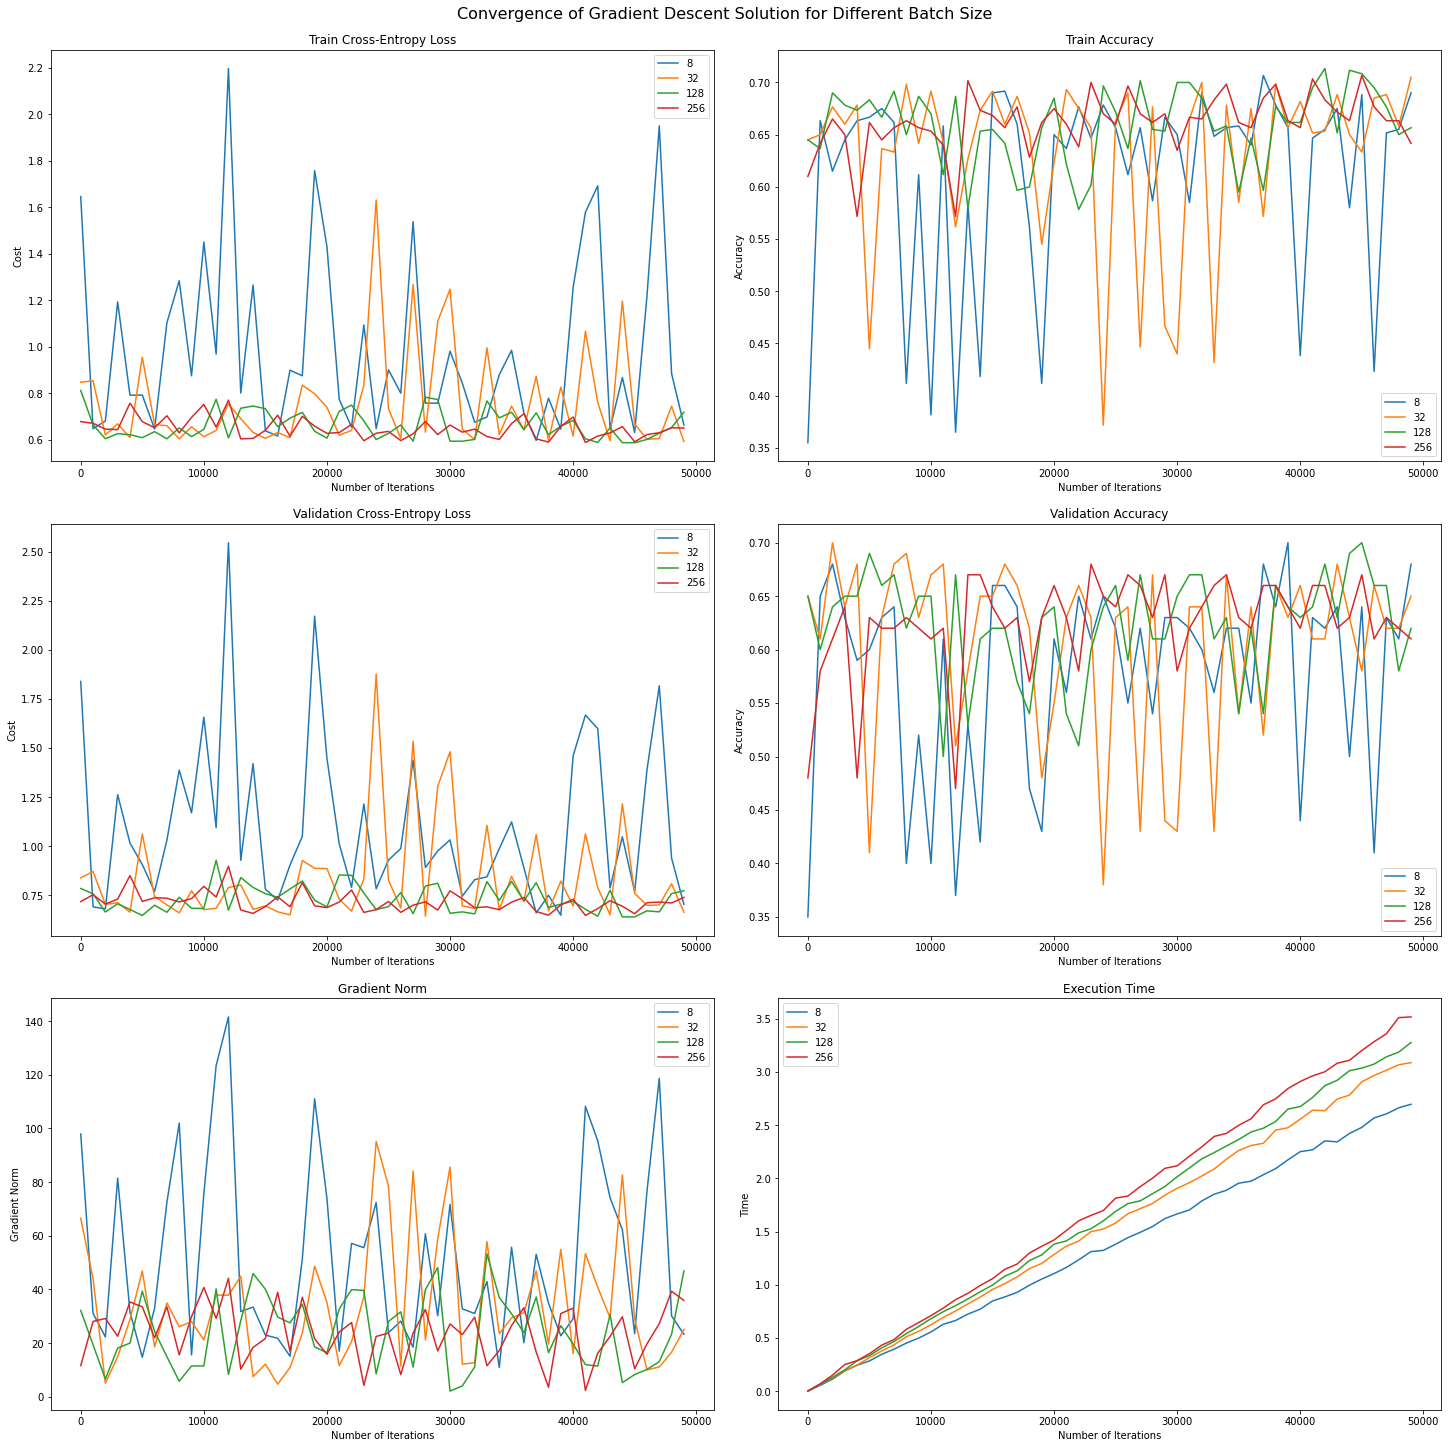

Minimal train cost: 0.5884144593922226
Batch Size: 128
Number of iterations: 44005

Minimal validation cost: 0.6407405230828735
Batch Size: 128
Number of iterations: 44005

Maximal train accuracy: 0.7133333333333334
Batch Size: 128
Number of iterations: 42005

Maximal validation accuracy: 0.7
Batch Size: 8
Number of iterations: 39005



In [114]:
batch_size_range = [8, 32, 128, 256]
max_iters_range = np.arange(5,50000,1000)
epsilon=0.01
gd_hypertuning_plots(param_range_type='bs', param_range=batch_size_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.0003, stochastic=True, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

The results show that the bigger the batch size the faster it converges. We try more iterations to make the solution converge with a batch size of 256. 

In [116]:
lr = 0.0003
max_iters = 20000000
epsilon = 0.01
batch_size=256

eval(lr, max_iters, epsilon, 1)

terminated after 891096 iterations, with norm of the gradient equal to 0.009999994849797442
the weight found: [ 1.31523943e-01  2.74274369e-02 -1.70725790e-02 -2.72180425e-03
  2.09585413e-04  5.10160001e-02  5.98868232e-01  2.92421731e-03
 -5.31172076e+00]
train accuracy: 0.7716666666666666
validation accuracy: 0.75
test accuracy: 0.7647058823529411


### **3. Gradient Descent with Momentum**

Add momentum to the gradient descent implementation. Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? Specifically, analyze the impact of momentum on the convergence speed and the quality of the final solution.


A momentum of 0.0 is the same as gradient descent without momentum.

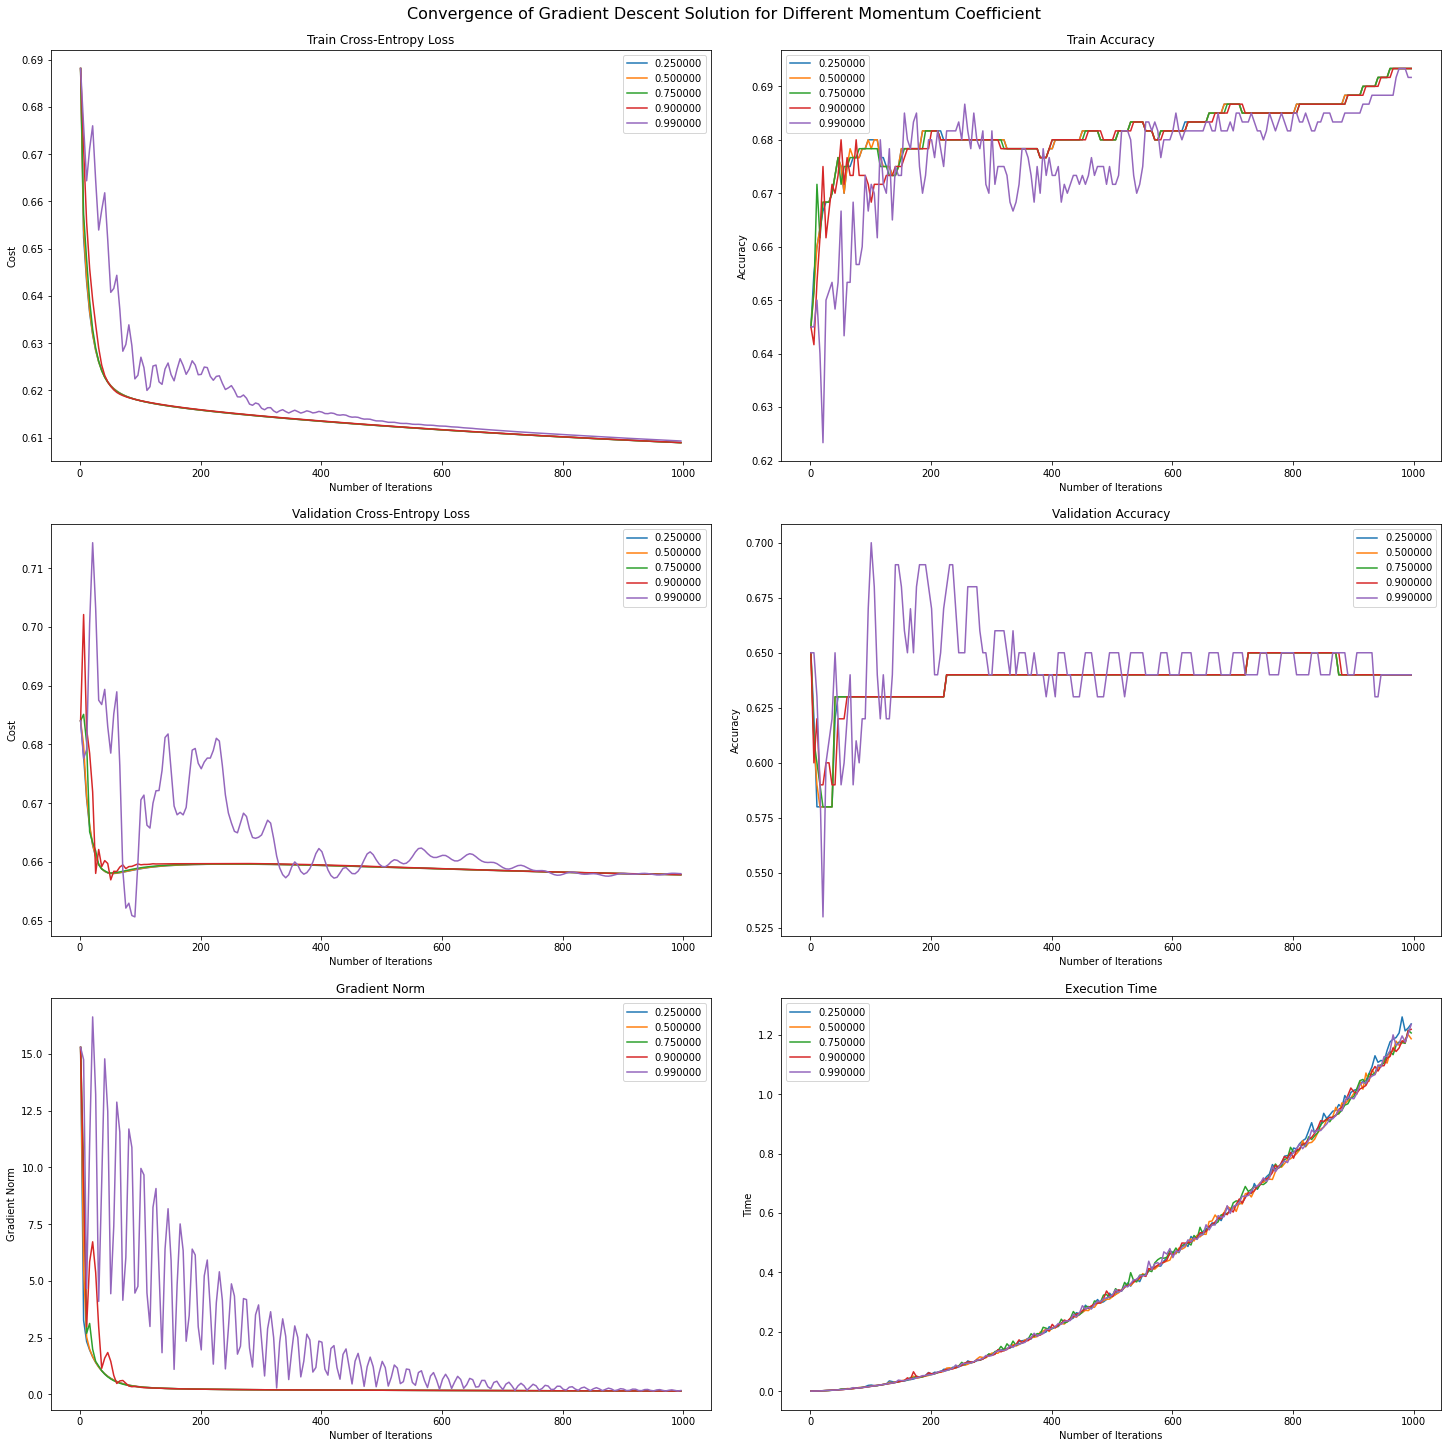

Minimal train cost: 0.6089292135060678
Momentum Coefficient: 0.25
Number of iterations: 996

Minimal validation cost: 0.6506380791802183
Momentum Coefficient: 0.99
Number of iterations: 91

Maximal train accuracy: 0.6933333333333334
Momentum Coefficient: 0.25
Number of iterations: 961

Maximal validation accuracy: 0.7
Momentum Coefficient: 0.99
Number of iterations: 101



In [117]:
momentum_coefficient_range = [0.25, 0.5, 0.75, 0.9, 0.99]
max_iters_range = np.arange(1,1000,5)
epsilon=0.01
gd_hypertuning_plots(param_range_type='mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.0003, stochastic=False, batch_size=1, momentum=True, momentum_coefficient=0.9, epsilon=epsilon)

In [113]:
def eval_momentum(lr, max_iters, epsilon, batch_size, momentum):
  
  stochastic=True
  if batch_size==1:
     stochastic=False 
      
  reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True, momentum=True, momentum_coefficient=momentum, stochastic=stochastic, batch_size=batch_size)
  reg.fit(x_train, y_train)

  # compute error
  yh_train, yh_val, yh_test = reg.predict(x_train), reg.predict(x_val), reg.predict(x_test)
  y_pred_train, y_pred_val, y_pred_test = np.rint(yh_train), np.rint(yh_val), np.rint(yh_test)
  acc_train, acc_val, acc_test = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val), accuracy(y_test, y_pred_test)

  print("train accuracy: {acc_train}".format(acc_train=acc_train))
  print("validation accuracy: {acc_val}".format(acc_val=acc_val))
  print("test accuracy: {acc_test}".format(acc_test=acc_test))

In [139]:
lr = 0.0003
max_iters = 5000
epsilon = 0.01

eval(lr, max_iters, epsilon, 1)

terminated after 5000 iterations, with norm of the gradient equal to 28.084483104422358
the weight found: [ 0.13167597  0.01721458 -0.03197651 -0.00196253  0.00501793 -0.00576148
  0.0096223  -0.00979267 -0.05384837]
train accuracy: 0.6316666666666667
validation accuracy: 0.61
test accuracy: 0.6176470588235294


In [138]:
lr = 0.0003
max_iters = 5000
epsilon = 0.01

eval_momentum(lr, max_iters, epsilon, 1, 0.9)

terminated after 5000 iterations, with norm of the gradient equal to 0.040639482239296386
the weight found: [ 0.12070222  0.01347404 -0.03072902 -0.00097726  0.00157058 -0.00537365
  0.0096059  -0.0104658  -0.0537789 ]
train accuracy: 0.6916666666666667
validation accuracy: 0.67
test accuracy: 0.7058823529411765


### **4. Gradient Descent with Momentum using smallest and largest batch sizes from 2)**

Repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?


#### Mini-batch: batch_size = 8

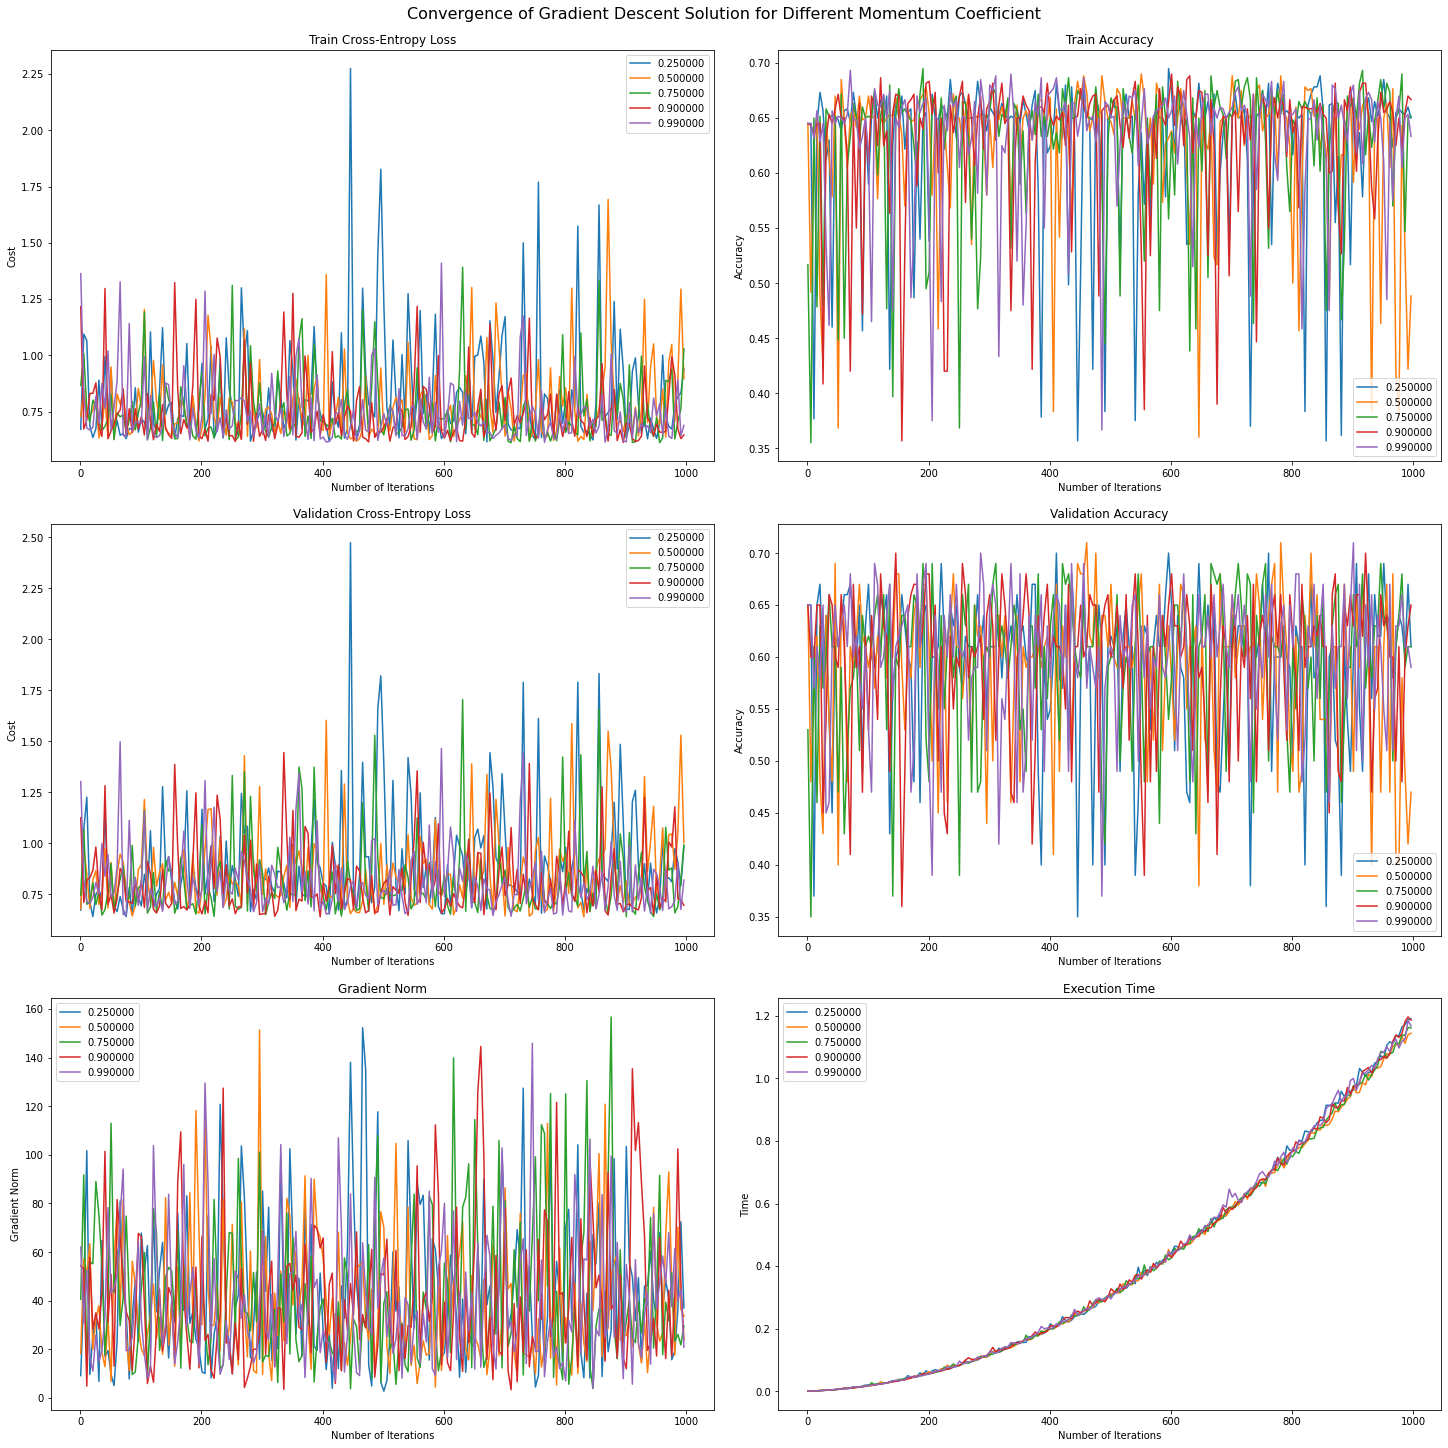

Minimal train cost: 0.611776595052079
Momentum Coefficient: 0.75
Number of iterations: 956

Minimal validation cost: 0.6397434617251015
Momentum Coefficient: 0.5
Number of iterations: 831

Maximal train accuracy: 0.695
Momentum Coefficient: 0.25
Number of iterations: 596

Maximal validation accuracy: 0.71
Momentum Coefficient: 0.5
Number of iterations: 461



In [118]:
momentum_coefficient_range = [0.25, 0.5, 0.75, 0.9, 0.99]
max_iters_range = np.arange(1,1000,5)
epsilon=0.01
min_bs = 8
gd_hypertuning_plots(param_range_type='mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.0003, stochastic=True, batch_size=min_bs, momentum=True, momentum_coefficient=0.9, epsilon=epsilon)

In [134]:
lr = 0.0003
max_iters = 10000
epsilon = 0.01
batch_size=8

eval(lr, max_iters, epsilon, batch_size)

terminated after 10000 iterations, with norm of the gradient equal to 33.00406400157907
the weight found: [ 0.18113626  0.02295835 -0.0525151  -0.00339064  0.008276   -0.01160294
  0.01975589 -0.00413953 -0.10590072]
train accuracy: 0.665
validation accuracy: 0.63
test accuracy: 0.6323529411764706


In [132]:
lr = 0.0003
max_iters = 10000
epsilon = 0.01
batch_size=8

eval_momentum(lr, max_iters, epsilon, batch_size, 0.9)

terminated after 10000 iterations, with norm of the gradient equal to 79.19222438869467
the weight found: [ 0.15250255  0.01829575 -0.02341497 -0.01088205  0.00266711 -0.00893783
  0.02228684 -0.01172397 -0.10483135]
train accuracy: 0.5866666666666667
validation accuracy: 0.57
test accuracy: 0.5294117647058824


In [135]:
lr = 0.0003
max_iters = 10000
epsilon = 0.01
batch_size=8

eval_momentum(lr, max_iters, epsilon, batch_size, 0.99)

terminated after 10000 iterations, with norm of the gradient equal to 9.695538502647638
the weight found: [ 0.16519473  0.01827463 -0.05735223 -0.00378474  0.00075846 -0.0120662
  0.01920452  0.00379843 -0.10410535]
train accuracy: 0.67
validation accuracy: 0.66
test accuracy: 0.6911764705882353


After 10,000 iterations, we see that momentum of 0.9 decreased accuracy and convergence speed from baseline, while momentum of 0.99 increased accuracy on validation set from 63% to 67%. 

#### Large-batch: batch_size = 256

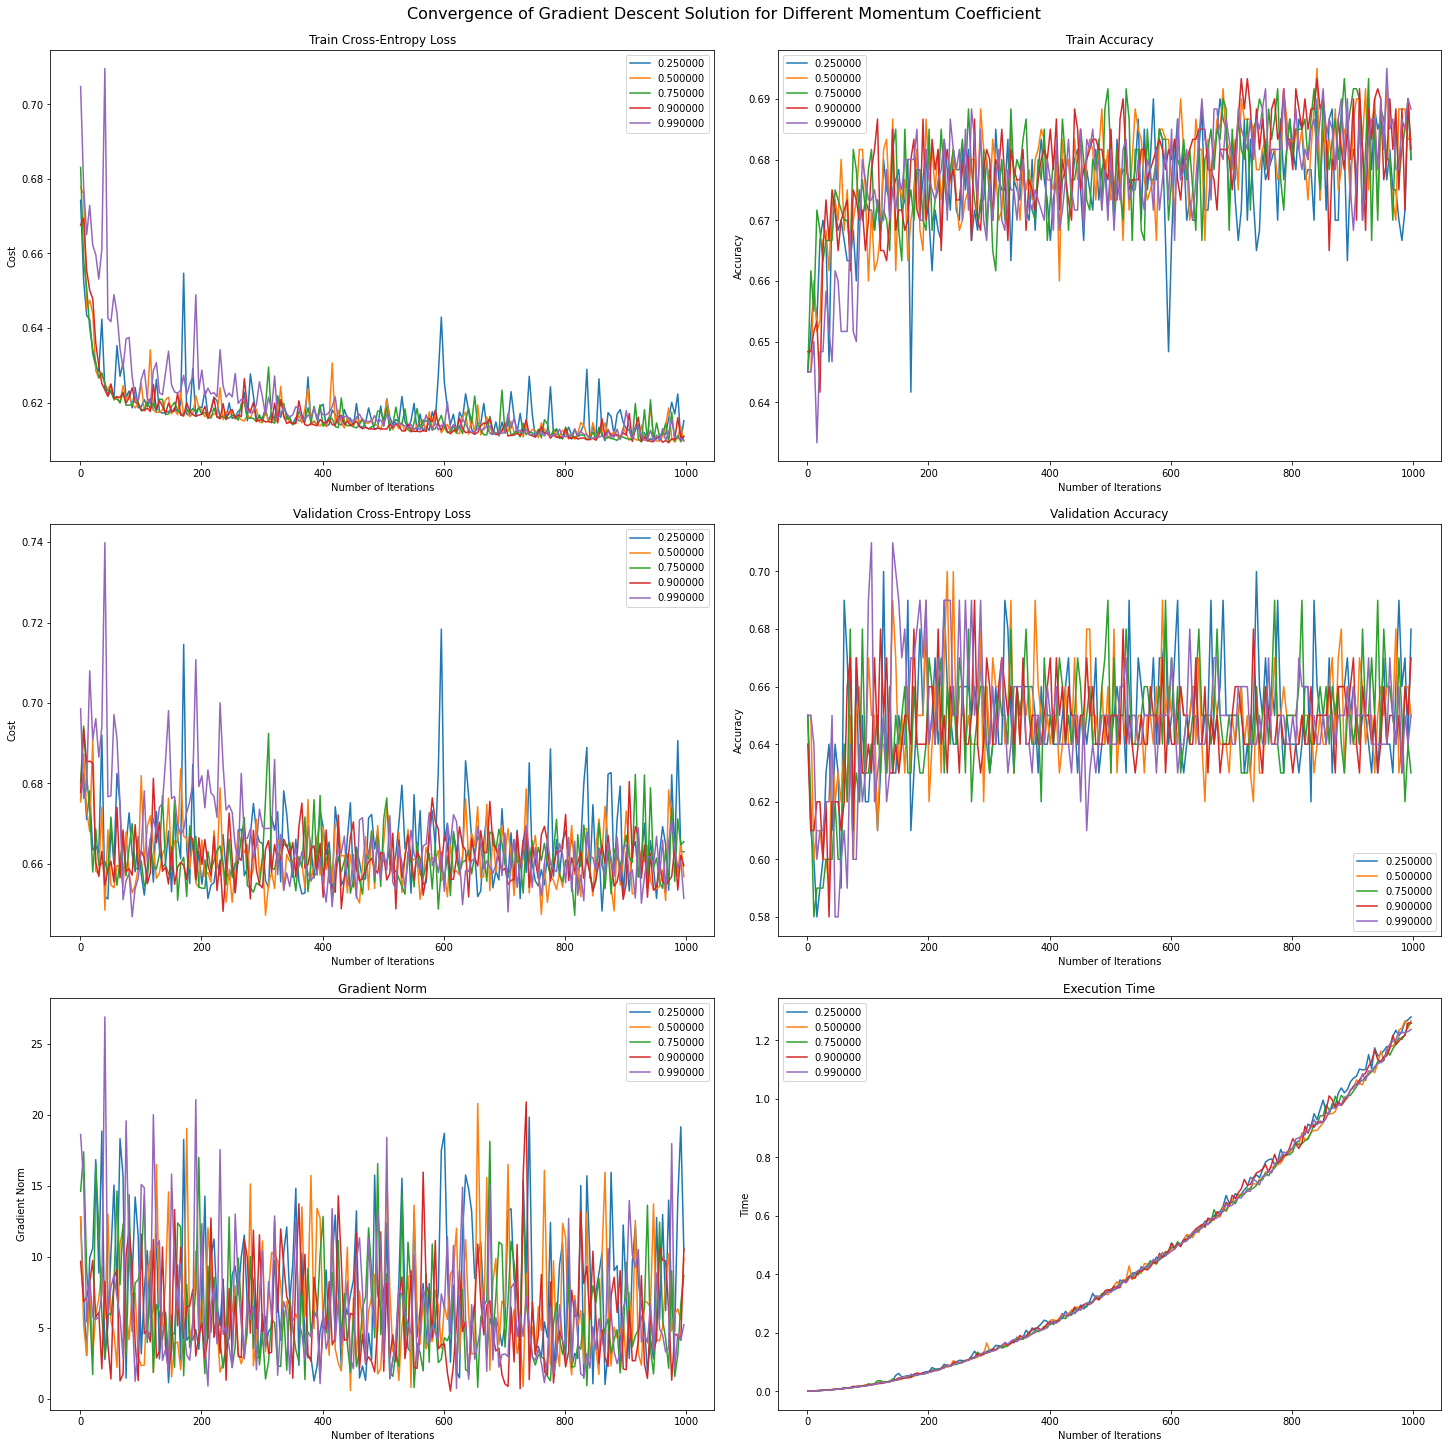

Minimal train cost: 0.6092171565985496
Momentum Coefficient: 0.9
Number of iterations: 971

Minimal validation cost: 0.6468281467734207
Momentum Coefficient: 0.99
Number of iterations: 86

Maximal train accuracy: 0.695
Momentum Coefficient: 0.5
Number of iterations: 841

Maximal validation accuracy: 0.71
Momentum Coefficient: 0.99
Number of iterations: 106



In [124]:
momentum_coefficient_range = [0.25, 0.5, 0.75, 0.9, 0.99]
max_iters_range = np.arange(1,1000,5)
max_bs = 256
epsilon=0.01
gd_hypertuning_plots(param_range_type='mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.0003, stochastic=True, batch_size=max_bs, momentum=True, momentum_coefficient=0.9, epsilon=epsilon)

In [136]:
lr = 0.0003
max_iters = 10000
epsilon = 0.01
batch_size=256

eval(lr, max_iters, epsilon, batch_size)

terminated after 10000 iterations, with norm of the gradient equal to 24.4176837949303
the weight found: [ 0.14363363  0.0120148  -0.03462313 -0.0029094  -0.00031594 -0.00645771
  0.02009098 -0.01370202 -0.10657025]
train accuracy: 0.6633333333333333
validation accuracy: 0.64
test accuracy: 0.6764705882352942


In [133]:
lr = 0.0003
max_iters = 10000
epsilon = 0.01
batch_size=256

eval_momentum(lr, max_iters, epsilon, batch_size, 0.9)

terminated after 10000 iterations, with norm of the gradient equal to 2.6636898042237767
the weight found: [ 0.13262971  0.01340269 -0.03084319 -0.00020706  0.00259346 -0.00605042
  0.01986396 -0.01160763 -0.10646107]
train accuracy: 0.69
validation accuracy: 0.64
test accuracy: 0.6911764705882353


In [137]:
lr = 0.0003
max_iters = 10000
epsilon = 0.01
batch_size=256

eval_momentum(lr, max_iters, epsilon, batch_size, 0.99)

terminated after 10000 iterations, with norm of the gradient equal to 5.436644901862423
the weight found: [ 0.13116473  0.01324443 -0.02949468 -0.00035677  0.00239544 -0.00524825
  0.01985471 -0.01156594 -0.10562816]
train accuracy: 0.6883333333333334
validation accuracy: 0.65
test accuracy: 0.7058823529411765


After 10,000 iterations, we see that momentum of 0.9 increased train accuracy and convergence speed from baseline but not validation accuracy, while momentum of 0.99 increased accuracy on validation set from 64% to 70.6%. 